## Program for simulating time and frequency offsets from the PySDR course

#### Imports

In [1888]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

#### Signal generation and pulse shaping

In [1889]:
# this part came from pulse shaping exercise
num_symbols = 100
sps = 8
bits = np.random.randint(0, 2, num_symbols) # Our data to be transmitted, 1's and 0's
pulse_train = np.array([])
for bit in bits:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    pulse_train = np.concatenate((pulse_train, pulse)) # add the 8 samples to the signal

# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-51, 52) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

# Filter our signal, in order to apply the pulse shaping
samples = np.convolve(pulse_train, h)
transmitted_samples = samples

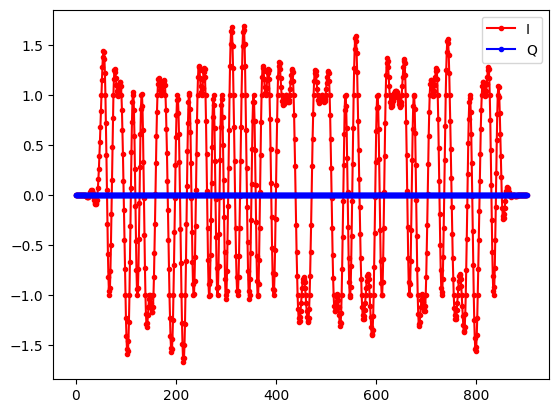

In [1890]:
plt.figure(0)
plt.plot(np.real(samples),'.-',label="I",color="red")
plt.plot(np.imag(samples),'.-',label="Q",color="blue")
plt.legend()
plt.show()

### Delay addition

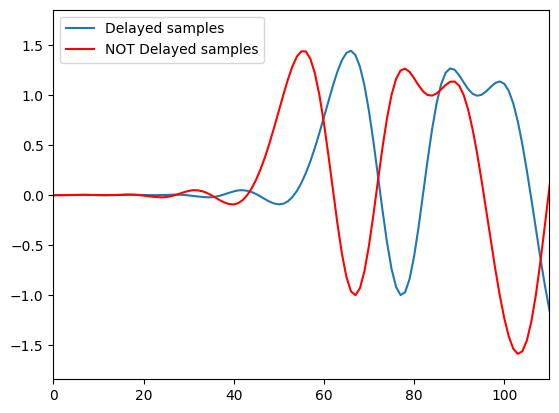

In [1891]:
delay = 0.4 # fractional delay, in samples
N = 21 # number of taps, keep this odd
n = np.arange(-(N-1)//2, N//2+1) # -10,-9,...,0,...,9,10
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power
samples = np.convolve(samples, h) # apply filter
plt.figure(0)

plt.plot(samples,label="Delayed samples")
plt.plot(transmitted_samples,label="NOT Delayed samples",color="red")
plt.xlim(0,110)
plt.legend()
plt.show()

### Adding a frequency offset

In [1892]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 13000 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector
samples = samples * np.exp(1j*2*np.pi*fo*t) # perform freq shift

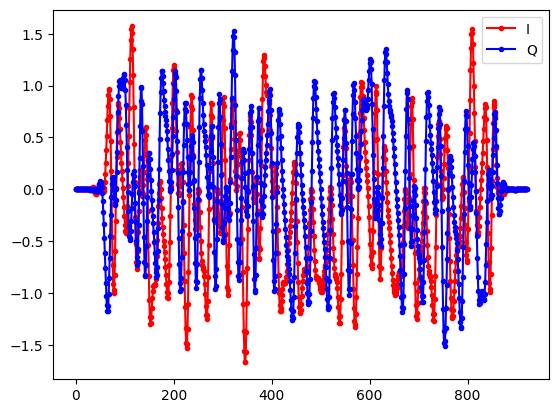

In [1893]:
plt.figure(0)
plt.plot(np.real(samples),'.-',label="I",color="red")
plt.plot(np.imag(samples),'.-',label="Q",color="blue")
plt.legend()
plt.show()

### CFO removal

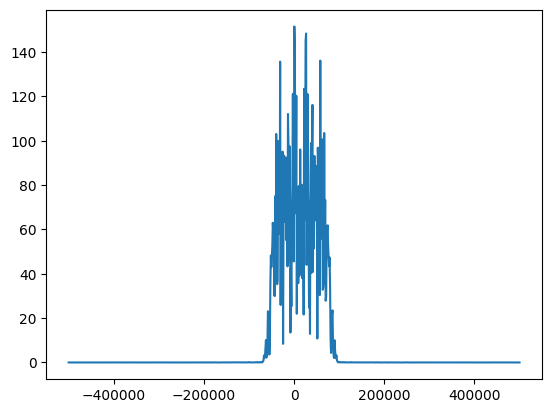

In [1894]:
psd = np.fft.fftshift(np.abs(np.fft.fft(samples)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
plt.plot(f, psd)
plt.show()

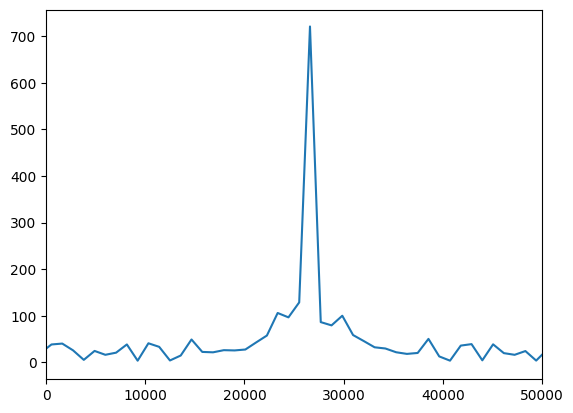

In [1895]:
original_samples = samples

samples = samples**2
psd = np.fft.fftshift(np.abs(np.fft.fft(samples)))
f = np.linspace(-fs/2.0, fs/2.0, len(psd))
plt.plot(f, psd)
plt.xlim(0,50000)
plt.show()

In [1896]:
samples = original_samples
print("INT CFO: ",f[np.argmax(psd)]/2)
max_freq = f[np.argmax(psd)]
Ts = 1/fs # calc sample period
t = np.arange(0, Ts*len(samples), Ts) # create time vector


samples = samples * np.exp(-1j*2*np.pi*max_freq*t/2)

INT CFO:  13300.760043431073


#### Time synchronization

In [1897]:
samples_interpolated = signal.resample_poly(samples, 16, 1)
before_time_sync = samples

mu = 0 # initial estimate of phase of sample
out = np.zeros(len(samples) + 10, dtype=np.complex64)
out_rail = np.zeros(len(samples) + 10, dtype=np.complex64) # stores values, each iteration we need the previous 2 values plus current value
i_in = 0 # input samples index
i_out = 2 # output index (let first two outputs be 0)

while i_out < len(samples) and i_in+16 < len(samples):
    out[i_out] = samples_interpolated[i_in*16 + int(mu*16)]
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.5*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples = out

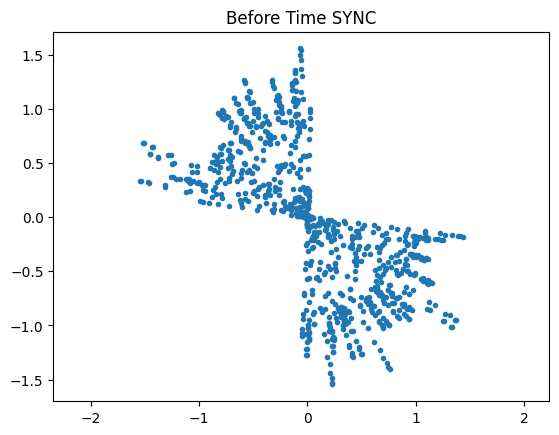

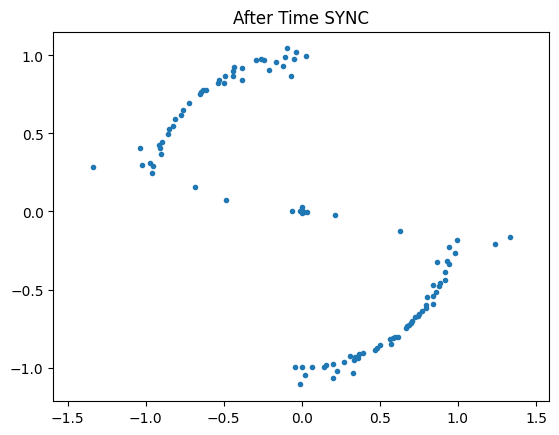

In [1898]:
plt.figure(0)
plt.plot(np.real(before_time_sync), np.imag(before_time_sync), '.')
plt.axis('equal')
plt.title("Before Time SYNC")
plt.show()

plt.figure(1)
plt.plot(np.real(samples), np.imag(samples), '.')
plt.axis('equal')
plt.title("After Time SYNC")
plt.show()

### Fine frequency synchronization

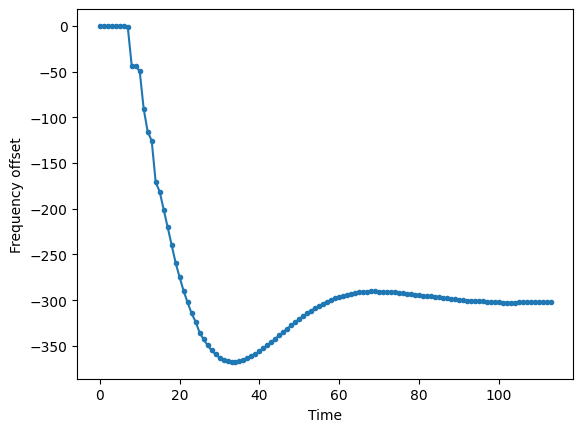

-302.20587


In [1899]:
N = len(samples)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.1
beta = 0.01
out = np.zeros(N, dtype=np.complex64)
freq_log = []

for i in range(N):
    out[i] = samples[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi*sps)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi

# Plot freq over time to see how long it takes to hit the right offset
plt.plot(freq_log,'.-')
plt.xlabel("Time")
plt.ylabel("Frequency offset")
plt.show()

corrected_freq = freq_log[-1]
samples=out
print(corrected_freq)

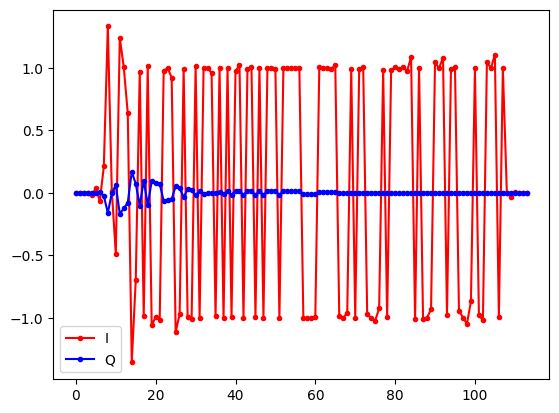

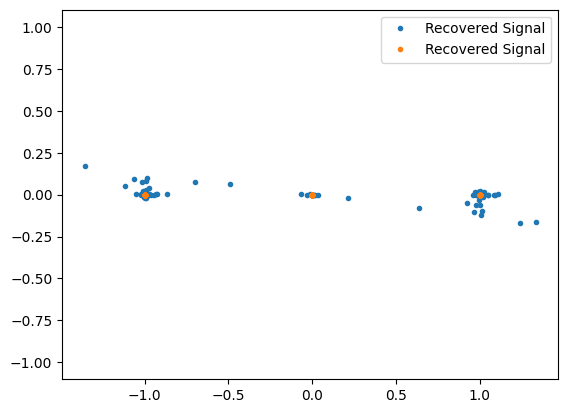

In [1900]:
plt.figure(0)
plt.plot(np.real(samples),'.-',label="I",color="red")
plt.plot(np.imag(samples),'.-',label="Q",color="blue")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(np.real(samples), np.imag(samples), '.',label="Recovered Signal")
plt.plot(np.real(pulse_train), np.imag(pulse_train), '.',label="Recovered Signal")
plt.legend()
plt.axis('equal')
plt.show()